In [1]:
import pandas as pd
import geopandas as gpd
import shapely

In [2]:
commuting_data_in = {}
commuting_data_out = {}
for i in range(1, 17):
    commuting_data_in[f"{i:02}"] = pd.read_excel(f"C:/Users/strobel/Projekte/open-data/BfA/krpend-{i:02}-0-202112-xlsx.xlsx", sheet_name="Einpendler Kreise", skiprows=6)
    commuting_data_out[f"{i:02}"] = pd.read_excel(f"C:/Users/strobel/Projekte/open-data/BfA/krpend-{i:02}-0-202112-xlsx.xlsx", sheet_name="Auspendler Kreise", skiprows=6)

In [3]:
workforce_stats = pd.read_excel("C:/Users/strobel/Projekte/open-data/BfA/gemband_dlk_0.xlsb", sheet_name="Gemeindedaten", skiprows=5)
workforce_stats = workforce_stats.rename(columns={"Unnamed: 0": "AGS", "Unnamed: 1": "Name", "Wohnort\ngleich\nArbeitsort": "InternalCommutes"})[[ "AGS", "Name", "InternalCommutes"]]
workforce_stats["AGS"] = workforce_stats["AGS"].dropna()
workforce_stats = workforce_stats[workforce_stats.AGS.apply(lambda x: 5 == len(str(x)) or str(x).endswith("000"))]
workforce_stats["AGS"] = workforce_stats["AGS"].apply(lambda x: str(x)[:5])
workforce_stats = workforce_stats.set_index("AGS")

In [4]:
def get_commuting_flows(for_area: str, direction: str):
    cols = ["Wohnort", "Arbeitsort", "Insgesamt"]
    if direction.lower() == "in":
        commuting_data = commuting_data_in[for_area[:2]][cols].copy()
        col_1 = 'Wohnort'
        col_2 = 'Arbeitsort'
    elif direction.lower() == "out":
        commuting_data = commuting_data_out[for_area[:2]][cols].copy()
        col_1 = 'Arbeitsort'
        col_2 = 'Wohnort'
    else:
        print(f"{direction} is not direction. Options: in, out")
        return
    
    # Fix excel formating
    commuting_data = commuting_data.fillna(method="ffill").replace("*", 0)
    # Filter Bundesländer and Bezirke
    commuting_data = commuting_data[commuting_data[col_1].apply(lambda x: len(str(x)) > 3)]
    # Get area
    commuting_data = commuting_data[commuting_data[col_2] == for_area]
    # Internal commuting
    commuting_data.loc[commuting_data.index.max()+1] = [for_area, for_area, workforce_stats.loc[for_area, "InternalCommutes"]]
    return commuting_data

def most_relevant(for_area: str):
    relevant_counties = set()
    for direction in ["in", "out"]:
        commuting_flows = get_commuting_flows(for_area, direction)
        # Get most relevant
        commuting_flows = commuting_flows.sort_values("Insgesamt", ascending=False)
        commuting_flows["cumsum_perc"] = commuting_flows.Insgesamt.cumsum()/ commuting_flows.Insgesamt.sum()
        commuting_flows = commuting_flows[commuting_flows.cumsum_perc <= 0.95]
        
        relevant_counties.update(commuting_flows["Arbeitsort"].to_list())
        relevant_counties.update(commuting_flows["Wohnort"].to_list())
    return relevant_counties

def make_od(relevant_counties):
    ods = pd.DataFrame(index=relevant_counties, columns=relevant_counties)
    for county in relevant_counties:
        for direction in ["in", "out"]:
            commuting_flows = get_commuting_flows(county, direction)
            commuting_flows = commuting_flows[commuting_flows.Wohnort.isin(relevant_counties) & commuting_flows.Arbeitsort.isin(relevant_counties)]
            # Pivot data
            od_county = commuting_flows.pivot(index=["Wohnort"], columns=["Arbeitsort"], values=["Insgesamt"])
            # Fix indices
            od_county.columns = od_county.columns.droplevel(0)
            od_county = od_county.rename_axis("Origin").rename_axis("Destination", axis=1)
            ods.loc[od_county.index, od_county.columns] = od_county
    return ods

In [5]:
relevant_counties = set()
relevant_counties.update(most_relevant('09462'))
relevant_counties.update(most_relevant('09472'))

In [6]:
krs = gpd.read_file("C:/Users/strobel/Projekte/esmregio/Daten/AdminGebiete/vg250_ebenen_0101/VG250_KRS.shp")
krs = krs[krs.AGS.isin(relevant_counties)][:-1] # Drop second hamburg (is it the harbor?)
krs = krs.to_crs(4326)

<AxesSubplot:>

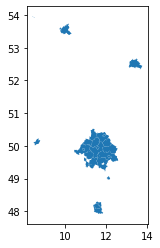

In [7]:
krs.plot()

In [8]:
from shapely.geometry import Point

In [9]:
osm_ids = "-62640"
buildings = pd.read_csv(f"../Buildings{osm_ids}.csv")
geometry = [Point(x, y) for x, y in zip(buildings['lon'], buildings['lat'])]
buildings = gpd.GeoDataFrame(buildings, geometry=geometry, crs=4326)

In [10]:
tst = gpd.sjoin(krs, buildings, predicate="contains")

In [11]:
tst.groupby("AGS").count()

,ADE,GF,BSG,ARS,SDV_ARS,GEN,BEZ,IBZ,BEM,NBD,...,lat,lon,population,landuse,region_type_RegioStaR7,number_shops,number_offices,number_schools,number_universities,InFocusArea
AGS,,,,,,,,,,,,,,,,,,,,,
09462,19202,19202,19202,19202,19202,19202,19202,19202,19202,19202,...,19202,19202,19202,19202,19202,19202,19202,19202,19202,19202
09472,25528,25528,25528,25528,25528,25528,25528,25528,25528,25528,...,25528,25528,25528,25528,25528,25528,25528,25528,25528,25528
09477,3099,3099,3099,3099,3099,3099,3099,3099,3099,3099,...,3099,3099,3099,3099,3099,3099,3099,3099,3099,3099


In [17]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib qt
f, ax = plt.subplots()
krs.plot(ax=ax)
buildings.plot(ax=ax, color="0", markersize=1)

<AxesSubplot:>